#NMTFD 2: Practical 1
Arjun Lenan Sandhya, Salman Salim

Importing the neccesary libraries

In [ ]:
%matplotlib inline
import sys
import numpy as np
import scipy.linalg as scla
import matplotlib.pyplot as plt
import math as mt
import matplotlib.pylab as pylab
from chebdif import chebdif
import pandas as pd

Loading the data from amp.stat

In [ ]:
amp = np.loadtxt('amp.stat')
re=4200
reb=amp[0,12]


Obtained these variables from .\bla\wampbl.f line 18-31

In [ ]:
data=pd.DataFrame(amp,columns=['time',
                                'Streamwise velocity average without (0,0) comp. (squared)' 'Normal velocity  average without  (squared)',
                                'Spanwise velocity average without (0,0) (squared)',
                                'Streamwise vorticity average without (0,0) comp. (squared)',
                                'Normal vorticity average (squared)',
                                'Spanwise vorticity average without (0,0) comp.(squared)',
                                'Normal vorticity squared over wavenumber square',
                                'average, no (0,0)',
                                'Reynolds stress average',
                                'Mean streamwise disturbance velocity',
                                'Mean spanwise disturbance velocity',
                                'Mean streamwise vorticity component',
                                'Mean spanwise vorticity component (to calculate wall shear)',
                                'Upper du/dy',
                                'lower du/dy',
                                'no idea1',
                                'no idea2',
                                'no idea3',
                                'no idea4'])

Computing the time series data of retau and utau for upper and lower wall

In [ ]:
t=amp[:,0]
n=t.size

#computing the utau and retau for both upper wall
#upper wall
utau1 = np.sqrt( amp[:,13]/re)
retau1 = utau1*re
#lower wall
utau2 = np.sqrt(-amp[:,14]/re)
retau2 = utau2*re

#average of retau from both side of wall and across the whole the time
retau = (np.mean(retau1[int(n/2):n])+np.mean(retau2[int(n/2):n]))/2

print('Re=%.5f Reb=%.5f Retau=%.5f' % (re,reb,retau) )

Re=4200.00000 Reb=2800.00000 Retau=189.30082


Plot of retau of upper and lower wall against time

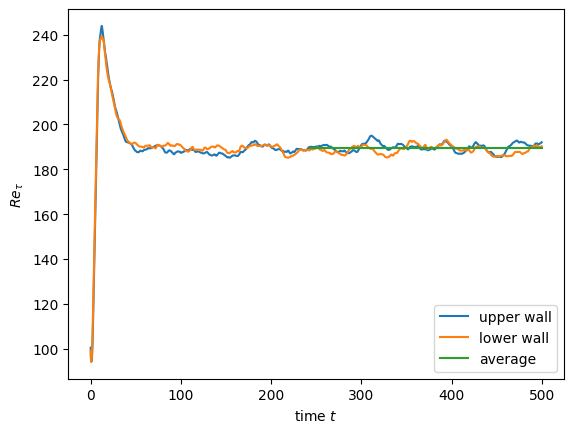

In [ ]:
fig=plt.figure()
plt.plot(t,retau1,label='upper wall')
plt.plot(t,retau2,label='lower wall')
plt.plot((t[int(n/2)],t[n-1]),(retau,retau),label='average')
plt.xlabel('time $t$')
plt.ylabel(r'$Re_{\tau}$')
plt.legend(loc='lower right')
plt.show()

Functions to find the correlation time

In [ ]:
def return_wall_corrlag(shear_df,col):
    """Function to calculate correlation lag where correlation turns < 0.1"""
    corr = 1
    n=1
    while corr > 0.1:
        corr = shear_df[col].autocorr(lag=n)
        #print(f"n: {n}, corr: {corr}")
        n += 1
    return n

def compute_avg_corrtime(shear_df, lag):
    """Function to compute average correlation time"""
    return shear_df["time"].loc[::lag].diff().dropna().mean()

def return_time_intervals(shear_df):
	"""Function to return a list of correlation time intervals"""
	starting_time_val = shear_df["time"].iloc[0]
	ending_time_val = shear_df["time"].iloc[-1]
	mark = starting_time_val
	time_steps = []
	while mark < ending_time_val or mark==0:
		time_steps.append(mark)
		mark += average_corrtime
	return time_steps

Manipulating the data to discard the transient values

In [ ]:

"""Converting read data into pandas dataframe"""
shear_df = pd.DataFrame({'time':amp[:,0], 'tau_wall1':amp[:,13]/re, 'tau_wall2':amp[:,14]/re})

"""Removing transients"""
shear_df = shear_df[shear_df["time"]>200]
shear_df = shear_df.reset_index(drop=True)

#calculating tau_wall and utau an retau for the upper and lower wall
shear_df["tau_wall"] = 0.5*(shear_df["tau_wall1"] - shear_df["tau_wall2"])
shear_df["Utau1"] = np.sqrt(shear_df["tau_wall1"])
shear_df["Utau2"] = np.sqrt(-shear_df["tau_wall2"])
shear_df["retau1"] = shear_df["Utau1"]*re
shear_df["retau2"] = shear_df["Utau2"]*re

Calculating the average of friction Reynolds number, Correlation time and wall shear stress

In [ ]:
mean_retau = 0.5*(shear_df["retau1"].mean()+shear_df["retau2"].mean())
avg_wall_shear_stress = shear_df.loc[:, 'tau_wall'].mean()

wall1_lag = return_wall_corrlag(shear_df,col="tau_wall1")
wall2_lag = return_wall_corrlag(shear_df,col="tau_wall2")
wall1_corrtime = compute_avg_corrtime(shear_df,wall1_lag)
wall2_corrtime = compute_avg_corrtime(shear_df,wall2_lag)
average_corrtime = (wall1_corrtime+wall2_corrtime)*0.5

print(f"Average correlation time is: {average_corrtime}")
print(f"Average friction Reynolds number is: {mean_retau}")
print(f"Average wall shear stress is: {avg_wall_shear_stress}")


Average correlation time is: 14.539850738360261
Average friction Reynolds number is: 189.1550319425057
Average wall shear stress is: 0.0020285326932539317


Plot of Wall shear stress after discarding transient values

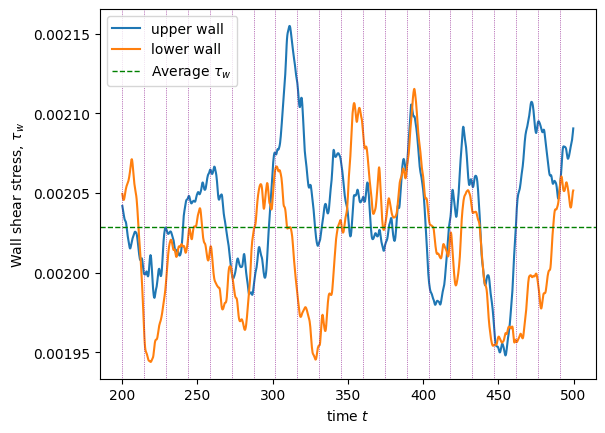

In [ ]:
time_steps = return_time_intervals(shear_df)
plt.figure(1)
plt.plot(shear_df["time"],shear_df["tau_wall1"],label="upper wall")
plt.plot(shear_df["time"],-shear_df["tau_wall2"],label="lower wall")
for xc in time_steps:
    plt.axvline(x=xc, color="purple", ls=':', lw=0.5)
plt.axhline(y=avg_wall_shear_stress,color="green",ls="--",lw=1,label=r"Average $\tau_{w}$")
plt.xlabel("time $t$")
plt.ylabel(r"Wall shear stress, ${\tau}_{w}$")
#plt.title(r"${\tau}_{w}$ v/s $t$ plot with correlation time interval of $14.5398s$")
plt.legend(loc="upper left")
plt.show()

Plot of Friction Reynolds number after discarding transient values

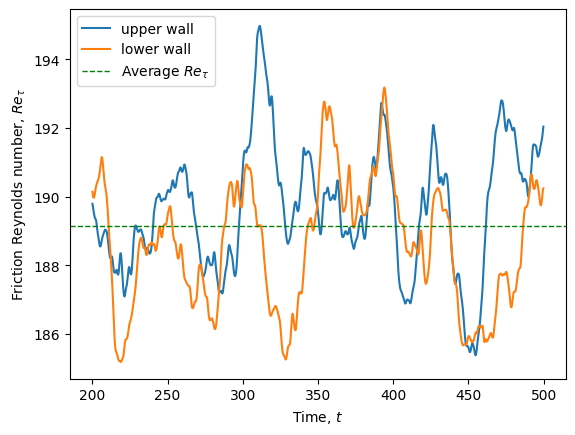

In [ ]:
plt.figure(2)
plt.plot(shear_df["time"],shear_df["retau1"],label="upper wall")
plt.plot(shear_df["time"],shear_df["retau2"],label="lower wall")
plt.axhline(y=mean_retau,color="green",ls="--",lw=1,label=r"Average $Re_{\tau}$")
plt.xlabel("Time, $t$")
plt.ylabel(r"Friction Reynolds number, $Re_{\tau}$")
#plt.title(r"$Re_{\tau}$ v/s $t$ plot")
plt.legend(loc="upper left")
plt.show()